# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption

This notebook is accompanied by a Youtube tutorial.

[WATCH THE VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
# !pip install pandas numpy matplotlib seaborn xgboost scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error #Used MSE
color_pal = sns.color_palette() #style for color palette from Seaborn
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
#check end or max value
df.tail() 

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


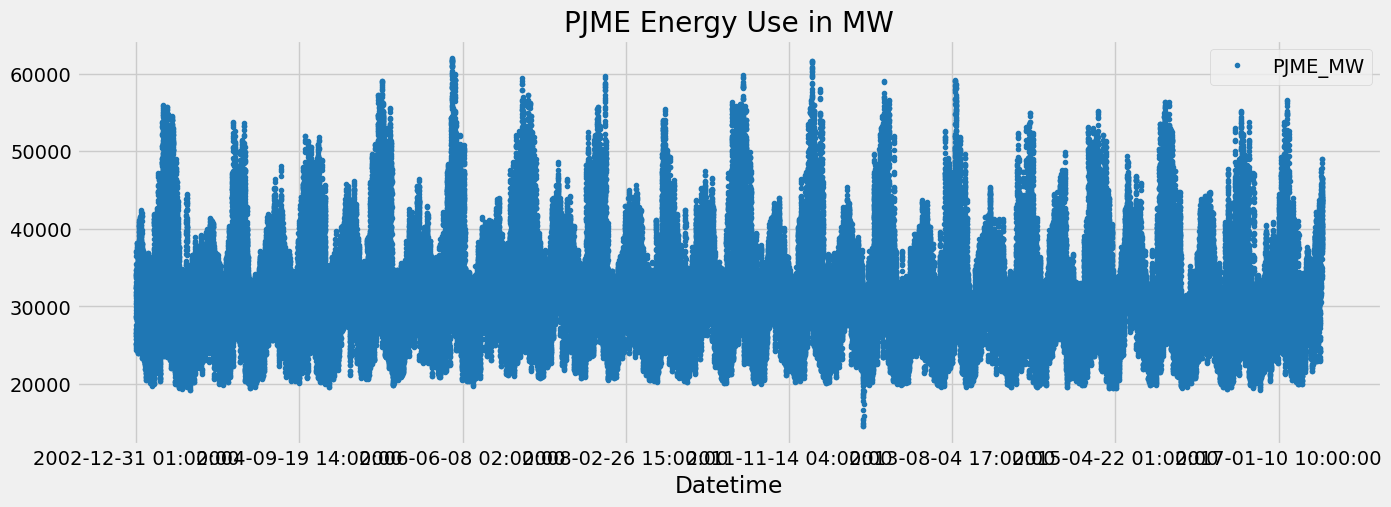

In [6]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [7]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [8]:
#Convert an object type to Datetime in order to access the values (e.g. Day, Year etc.)
df.index = pd.to_datetime(df.index)

In [9]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# Outlier Analysis and Removal

# Train / Test Split

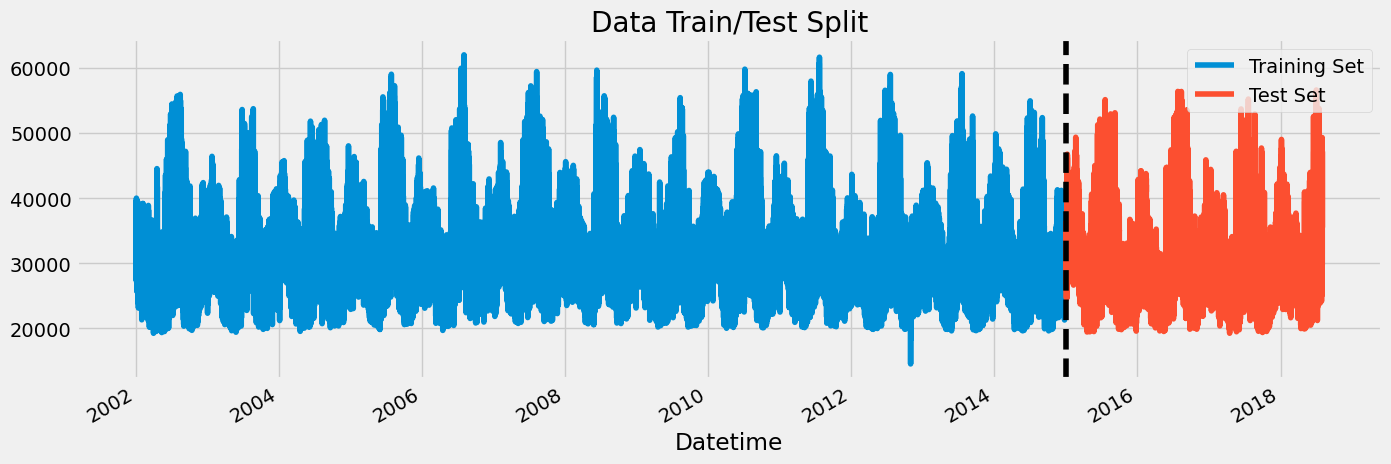

In [10]:
train = df.loc[df.index < '01-01-2015'] #Training before Jan 1 2015
test = df.loc[df.index >= '01-01-2015'] #Testing on data after Jan 1 2015

#Must be declared in this order
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2015', color='black', ls='--')  #dashed divider
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [12]:
test

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


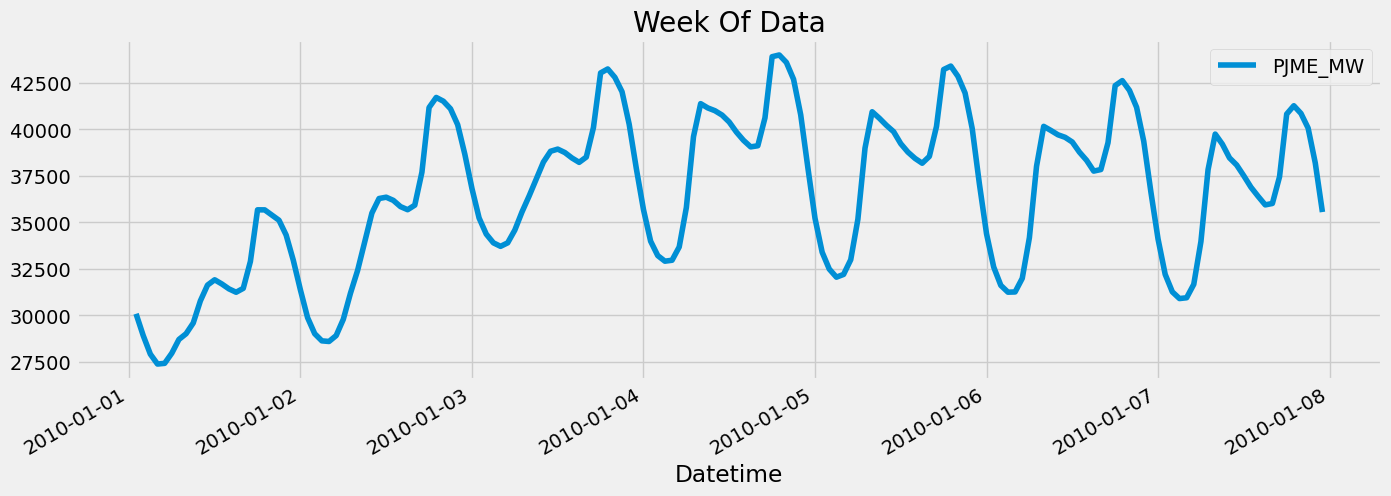

In [13]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')

# In one line it is
#df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [14]:
#To inspect further, include the time/hour in x-axis to analyze the peaks and lows

# Feature Creation

From the train and test data, we see a 2D data of 1.) "Combined" Datetime and 2.) energy consumption in MW

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [16]:
df.index.hour
df['hour'] = df.index.hour
df['hour']

Datetime
2002-12-31 01:00:00     1
2002-12-31 02:00:00     2
2002-12-31 03:00:00     3
2002-12-31 04:00:00     4
2002-12-31 05:00:00     5
                       ..
2018-01-01 20:00:00    20
2018-01-01 21:00:00    21
2018-01-01 22:00:00    22
2018-01-01 23:00:00    23
2018-01-02 00:00:00     0
Name: hour, Length: 145366, dtype: int64

In [17]:
df.index.month
df['month'] = df.index.month
df['month']

Datetime
2002-12-31 01:00:00    12
2002-12-31 02:00:00    12
2002-12-31 03:00:00    12
2002-12-31 04:00:00    12
2002-12-31 05:00:00    12
                       ..
2018-01-01 20:00:00     1
2018-01-01 21:00:00     1
2018-01-01 22:00:00     1
2018-01-01 23:00:00     1
2018-01-02 00:00:00     1
Name: month, Length: 145366, dtype: int64

# Visualize our Feature / Target Relationship

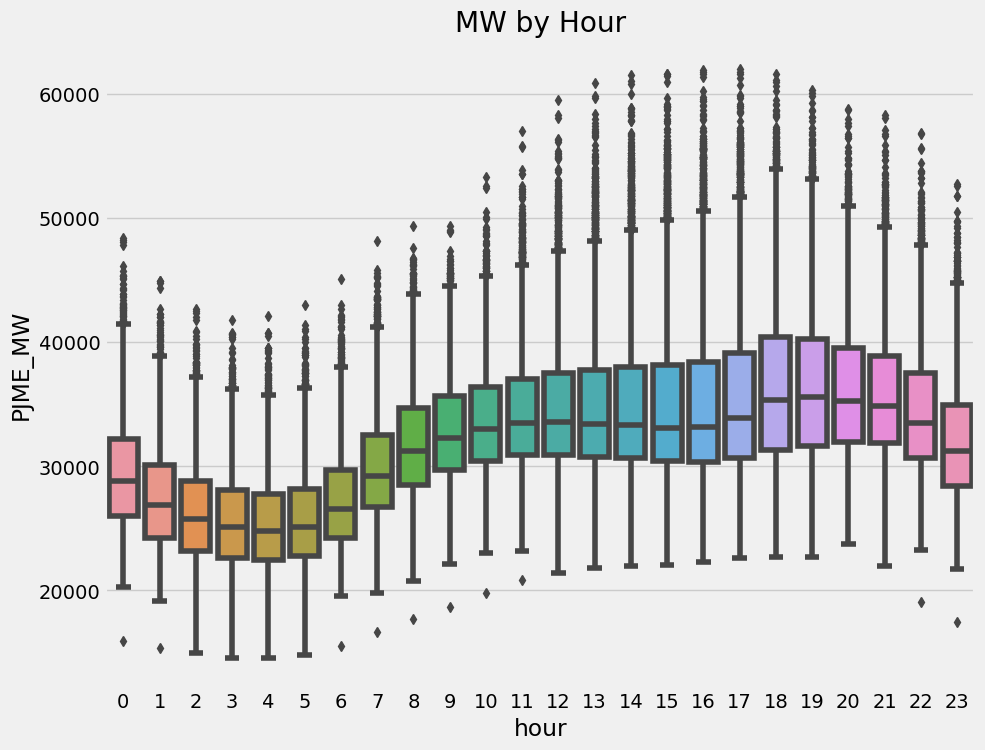

In [18]:
#Boxplots are useful to get a distribution of the dataset

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

# ANALYSIS
In the morning there is a dip in energy consumption and it it peaks around 16:00 - 19:00

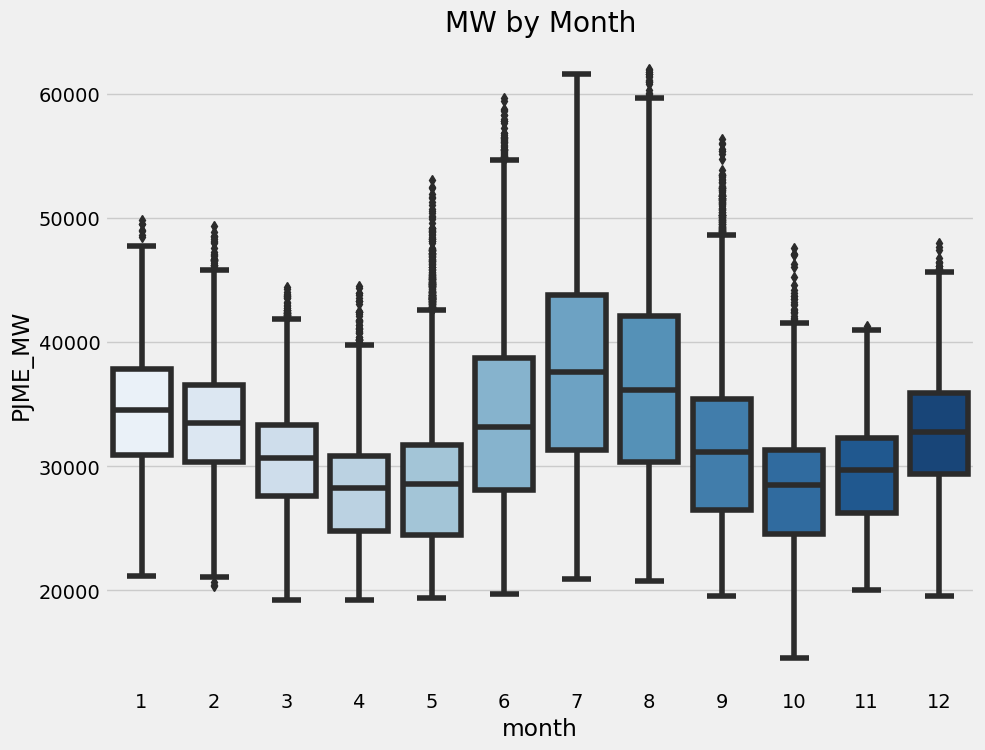

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# ANALYSIS
This is where location is important, in Australia month 6,7,8 would be cold but in other areas it may be Summer time.
 
2 peaks (1-2) and (6-8) while the rest are dips

# Create our Model

In [20]:
#Called here to split "combined features"

train = create_features(train)
test = create_features(test)

#We define features according to how it was split in the "create_features" functions ... BUT you don't
#have to use all the features.

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

In [21]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Regression Task therefore a Regressor class is used, where **n_estimators** is the number of trees,

In [22]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50, #If the model does not improve after 50 epochs, early stop
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

# use verbose = True if you want more detail 
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #verbose=True
        verbose=100
       )

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803


C:\Users\Professional\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:12:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

validation_0 refers to the training set and validation_1 refers to the test set.

The model was trained for 989 boosting iterations out of a maximum of 1000, with early stopping configured to halt training if no improvement was observed for 50 rounds. 

Both the training and test RMSE decreased substantially over training. The training RMSE dropped from approximately 32,605 to 3,060, while the test RMSE decreased from about 31,657 to 3,727.

During the early stages of training (roughly iterations 0–200), the test error was slightly lower than the training error, which can occur due to regularization and the simplicity of early trees. After around iteration 300, the test RMSE became consistently higher than the training RMSE, which is expected behavior as the model fits the training data more closely.

The gap between training and test RMSE remains relatively small and stable throughout the later stages of training, suggesting good generalization and no strong evidence of overfitting. Toward the end of training, improvements in test RMSE became marginal, indicating that the model had largely converged.

# Feature Importance

After XGBoost, you can now determine which features are used OR how important they are.

NOTE: if features "overlap" or are highly correlated, feature importance is not so highly reliable.

If we remove the month feature, the day of year feature would be used in it's place.

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi

,importance
dayofyear,0.138096
hour,0.349240
dayofweek,0.181862
quarter,0.057403
month,0.247377
year,0.026023


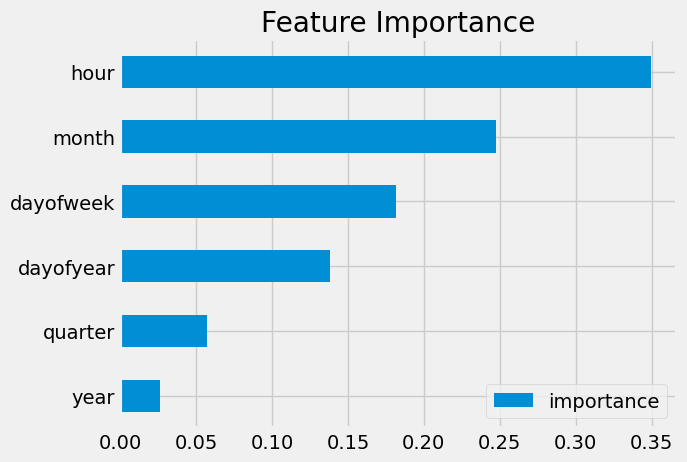

In [24]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [25]:
df['month'] = df.index.month
df['month']


Datetime
2002-12-31 01:00:00    12
2002-12-31 02:00:00    12
2002-12-31 03:00:00    12
2002-12-31 04:00:00    12
2002-12-31 05:00:00    12
                       ..
2018-01-01 20:00:00     1
2018-01-01 21:00:00     1
2018-01-01 22:00:00     1
2018-01-01 23:00:00     1
2018-01-02 00:00:00     1
Name: month, Length: 145366, dtype: int64

In [26]:
df['dayofyear'] = df.index.dayofyear
df['dayofyear'] 

Datetime
2002-12-31 01:00:00    365
2002-12-31 02:00:00    365
2002-12-31 03:00:00    365
2002-12-31 04:00:00    365
2002-12-31 05:00:00    365
                      ... 
2018-01-01 20:00:00      1
2018-01-01 21:00:00      1
2018-01-01 22:00:00      1
2018-01-01 23:00:00      1
2018-01-02 00:00:00      2
Name: dayofyear, Length: 145366, dtype: int64

# Forecast on Test

reg (i.e. XGBoost model) is now trained THEREFORE we test this model on the test dataset.

BECAUSE we were satisfied with the performance of the fitted model, we now decide to predict with future values

In [27]:
reg.predict(X_test)

array([30422.88 , 28121.424, 27169.205, ..., 36207.367, 33975.19 ,
       30068.2  ], dtype=float32)

In [28]:
# test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# df

#merge the two dataframes using the INDEX COLUMN

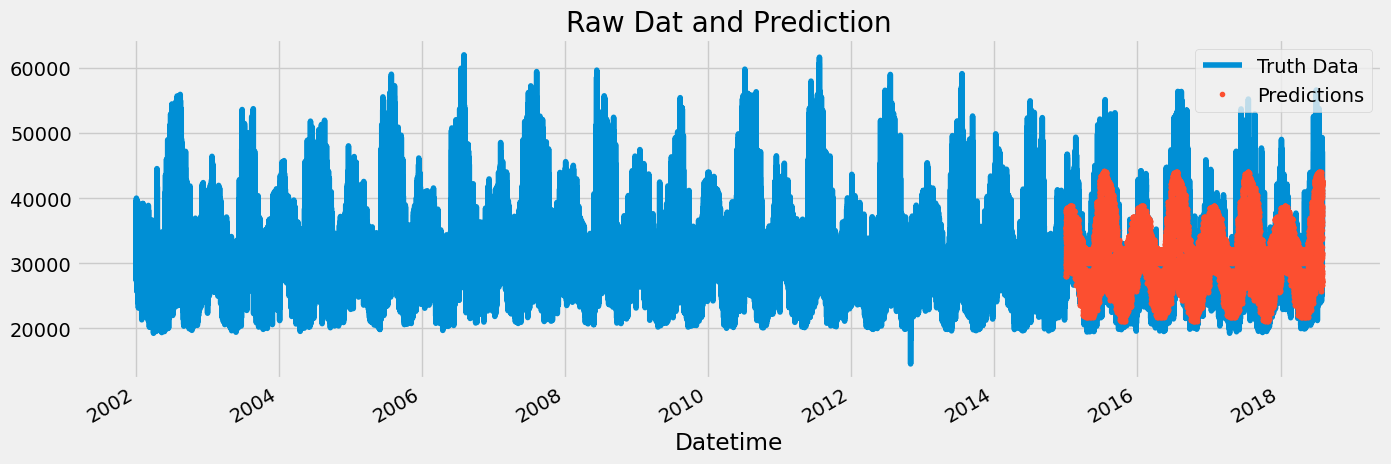

In [29]:
test['prediction'] = reg.predict(X_test)

#merged the 2 df
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

#visualizing the predicted values VS the test data
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

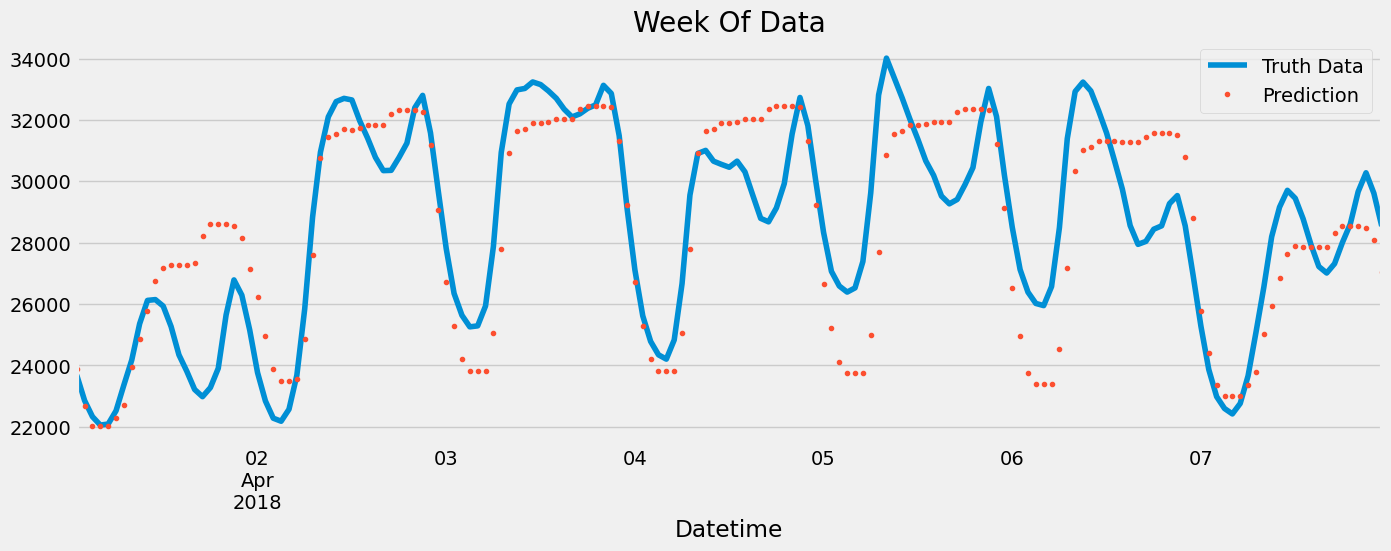

In [30]:
#Visualizing the prediction VS the blue ground truth on a weekly basis

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Good data analyst think of better ways to improve the model such as 1.) hyperparameter tuning 2.) including more features (e.g. holidays, non-working days)

# Score (RMSE)

In [31]:
test['PJME_MW']

Datetime
2015-01-01 00:00:00    32802.0
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 31440, dtype: float64

In [32]:
test['prediction']

Datetime
2015-01-01 00:00:00    30422.880859
2015-12-31 01:00:00    28121.423828
2015-12-31 02:00:00    27169.205078
2015-12-31 03:00:00    26777.427734
2015-12-31 04:00:00    26777.427734
                           ...     
2018-01-01 20:00:00    37738.308594
2018-01-01 21:00:00    37685.746094
2018-01-01 22:00:00    36207.367188
2018-01-01 23:00:00    33975.191406
2018-01-02 00:00:00    30068.199219
Name: prediction, Length: 31440, dtype: float32

In [33]:
#evaluating model performance ALWAYS "ground_truth[target]" as the first argument and "prediction[target]"
#as the second argument being passed
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

#np.sqrt effectively creates RMSE similar to XGBoost since it square roots the ALREADY mean_squared_error

#MSE evaluates
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


This calculates the average of squared differences between actual values and predictions.

Example: If actual = 100 and prediction = 90, the error = 10, squared = 100

# Calculate Error
- Look at the worst and best predicted days

In [36]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['error']

Datetime
2015-01-01 00:00:00    2379.119141
2015-12-31 01:00:00    3816.423828
2015-12-31 02:00:00    4013.205078
2015-12-31 03:00:00    4263.427734
2015-12-31 04:00:00    4447.427734
                          ...     
2018-01-01 20:00:00    6545.691406
2018-01-01 21:00:00    6065.253906
2018-01-01 22:00:00    6194.632812
2018-01-01 23:00:00    6188.808594
2018-01-02 00:00:00    8539.800781
Name: error, Length: 31440, dtype: float64

In [37]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

# T

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)
- Additional datasets: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=PJME_hourly.csv

# Sources

Rob Mulla